# Выбор локации для скважины

Мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Построим модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируем возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
# Импортируем основные библиотеки для работы
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Импортируем модели, метрики, вспомогательные инструменты и функции
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats as st

warnings.filterwarnings("ignore", category=FutureWarning) 
pd.set_option('display.max_columns', None)

state=np.random.RandomState(42)
random_state = 42
train_size = 0.75

## Загрузка и подготовка данных

### Загрузка и первичный анализ

Откроем файлы и сохраним их в переменных `geo_0`, `geo_1`, `geo_2`, получим основную информацию с помощью метода .info() и построим гистограммы для всех признаков датасета.

In [2]:
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Описание признаков в наборах данных:
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [6]:
geo_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [7]:
geo_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
geo_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


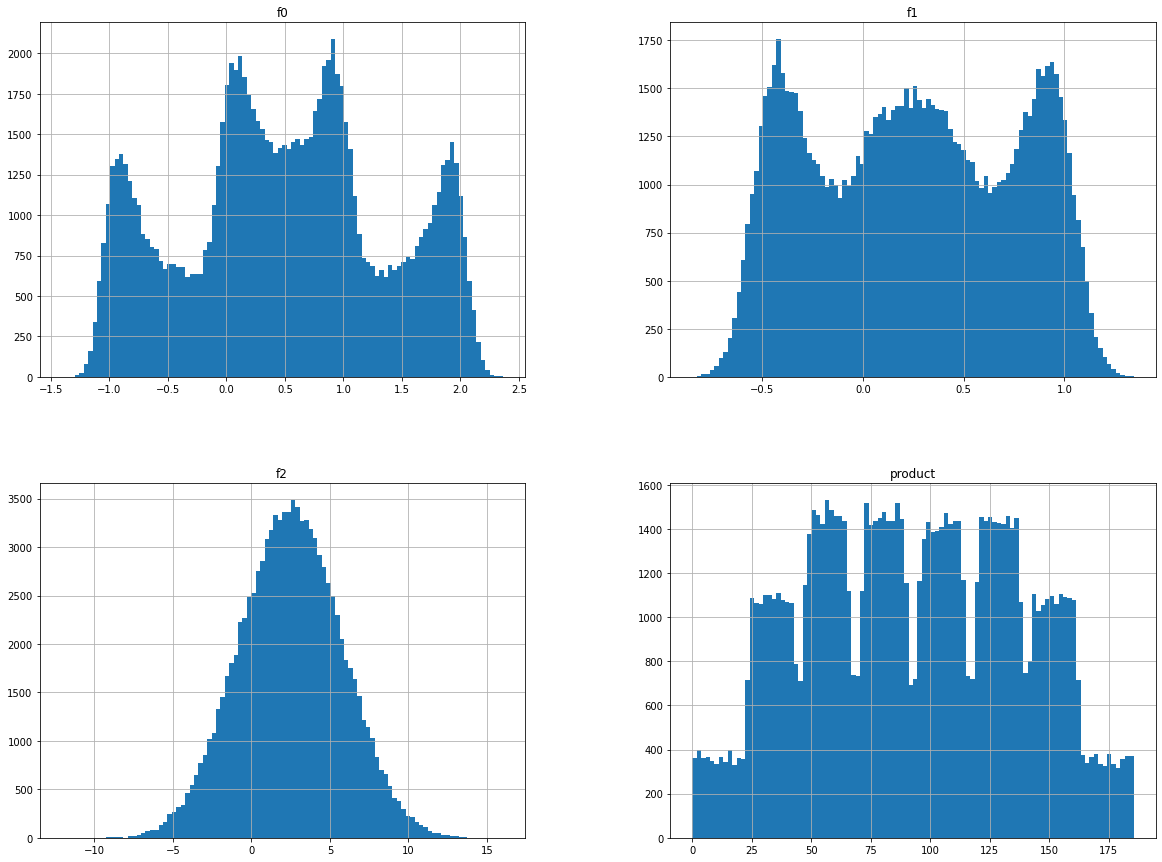

In [9]:
geo_0.hist(figsize=(20, 15), bins=100)
plt.show()

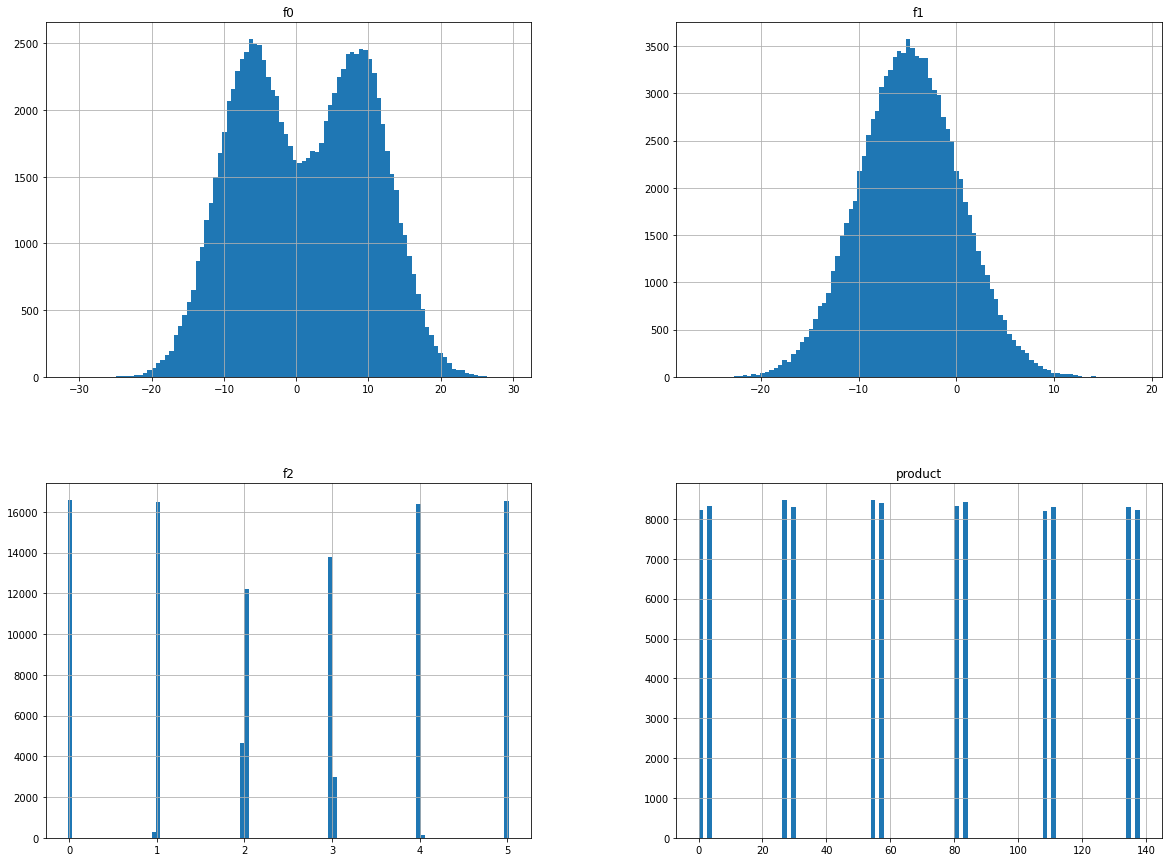

In [10]:
geo_1.hist(figsize=(20, 15), bins=100)
plt.show()

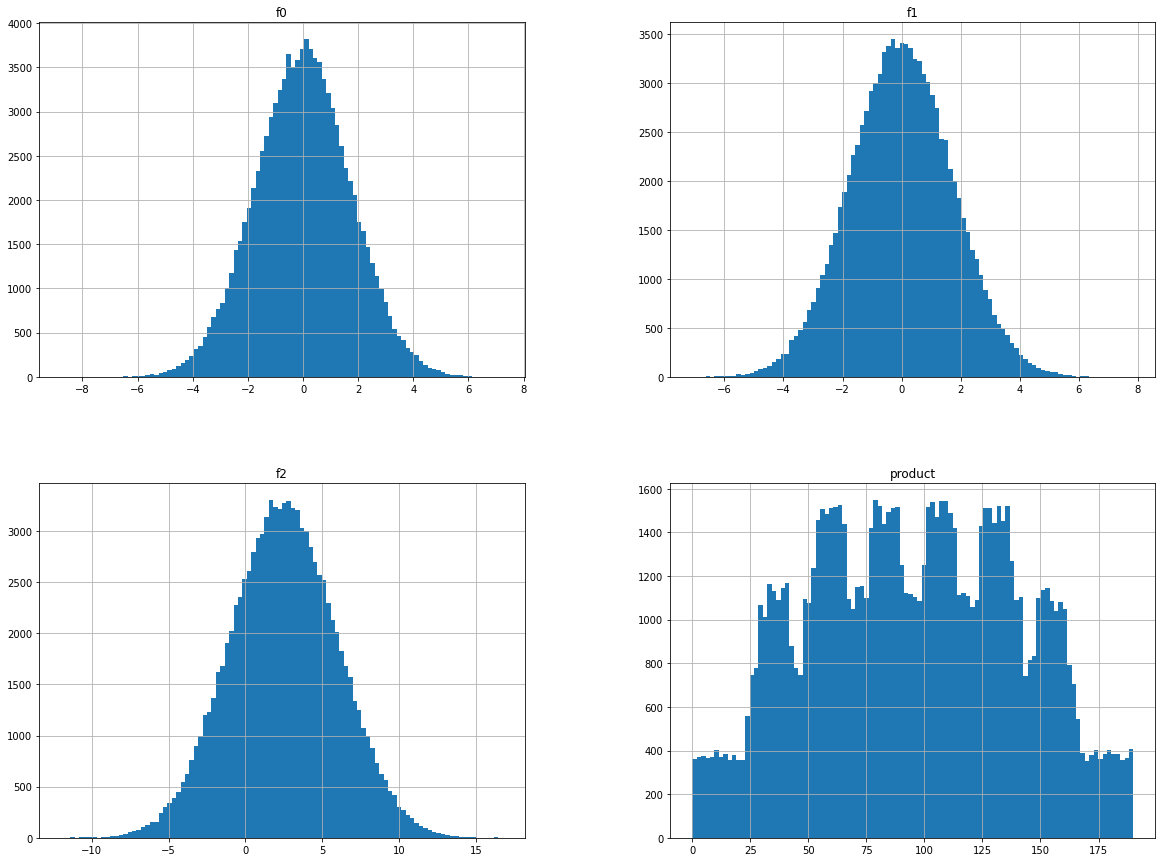

In [11]:
geo_2.hist(figsize=(20, 15), bins=100)
plt.show()

In [12]:
geo_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [13]:
geo_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [14]:
geo_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


---
**Вывод:** изучив основную информацию о датасетах, можно утверждать, что
- в датасетах есть признак, лишний для наших целей обучения моделей - "id"; 
- данные очищены - пропусков нет;
- на всякий случай имеет смысл проверить данные на дубликаты;
- признаки у датасетов имеют распределения без перекосов вправо/влево - очевидных выбросов нет;
- необходимо проверить данные на мультиколлинеарность;
- данные не стандартизированы - исправим это на этапе подготовки пайплайнов.

### Проверка на дубликаты

Проверим данные на дубликаты по "id":

In [15]:
geo_0[geo_0.duplicated(subset=['id'])].head()

,id,f0,f1,f2,product
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
66136,74z30,1.084962,-0.312358,6.990771,127.643327


In [16]:
geo_1[geo_1.duplicated(subset=['id'])].head()

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [17]:
geo_2[geo_2.duplicated(subset=['id'])].head()

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


Мы нашли дубликаты. Избавимся от более поздних дублирующихся строк.

In [18]:
print('Размер датасета geo_0 до удаления дубликатов:', geo_0.shape)
geo_0 = geo_0.drop_duplicates(subset=['id'], keep='first')
print('Размер датасета geo_0 после удаления дубликатов:', geo_0.shape)

Размер датасета geo_0 до удаления дубликатов: (100000, 5)
Размер датасета geo_0 после удаления дубликатов: (99990, 5)


In [19]:
print('Размер датасета geo_1 до удаления дубликатов:', geo_1.shape)
geo_1 = geo_1.drop_duplicates(subset=['id'], keep='first')
print('Размер датасета geo_1 после удаления дубликатов:', geo_1.shape)

Размер датасета geo_1 до удаления дубликатов: (100000, 5)
Размер датасета geo_1 после удаления дубликатов: (99996, 5)


In [20]:
print('Размер датасета geo_2 до удаления дубликатов:', geo_2.shape)
geo_2 = geo_2.drop_duplicates(subset=['id'], keep='first')
print('Размер датасета geo_2 после удаления дубликатов:', geo_2.shape)

Размер датасета geo_2 до удаления дубликатов: (100000, 5)
Размер датасета geo_2 после удаления дубликатов: (99996, 5)


### Очистка от лишних признаков

В датасетах у нас есть признак "id", который не несёт за собой никакой прогнозирующей силы, а служит только для идентификации скважин. При обучении моделей он помешает нам, удалим его.

In [21]:
geo_0 = geo_0.drop(columns=['id'])
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99990 non-null  float64
 1   f1       99990 non-null  float64
 2   f2       99990 non-null  float64
 3   product  99990 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [22]:
geo_1 = geo_1.drop(columns=['id'])
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [23]:
geo_2 = geo_2.drop(columns=['id'])
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   f0       99996 non-null  float64
 1   f1       99996 non-null  float64
 2   f2       99996 non-null  float64
 3   product  99996 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


Проверим, появились ли у нас после удаления id полностью дублирующиеся строки:

In [24]:
geo_0.duplicated().sum()

0

In [25]:
geo_1.duplicated().sum()

0

In [26]:
geo_2.duplicated().sum()

0

Дубликатов нет.

### Проверка на мультиколлинеарность

Проверим корреляцию признаков у датасетов.

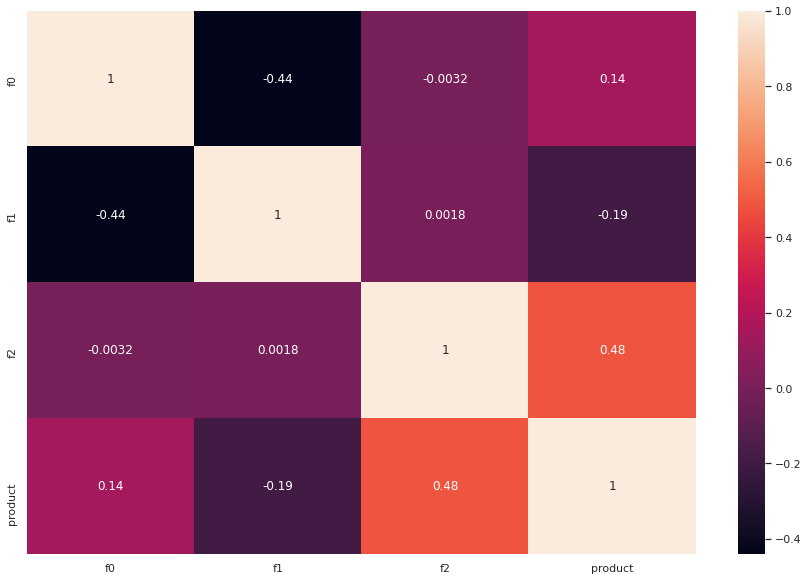

In [27]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(geo_0.corr(), annot=True)
plt.show()

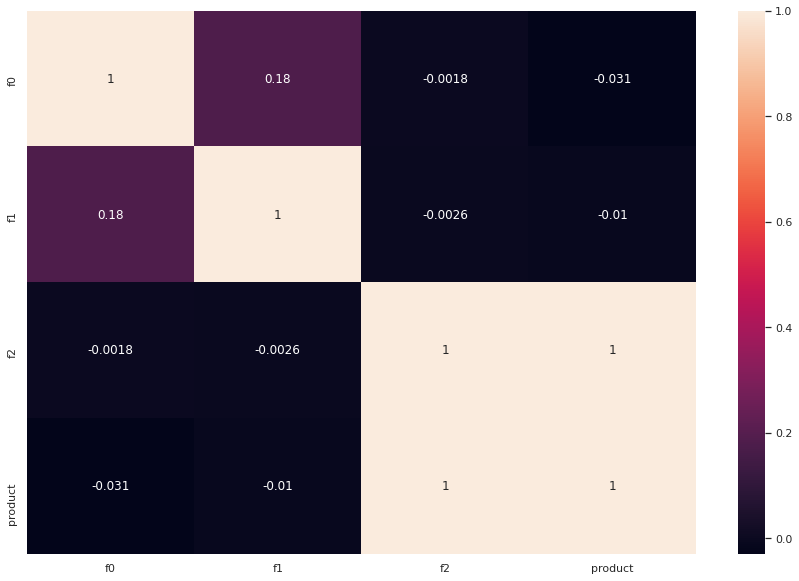

In [28]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(geo_1.corr(), annot=True)
plt.show()

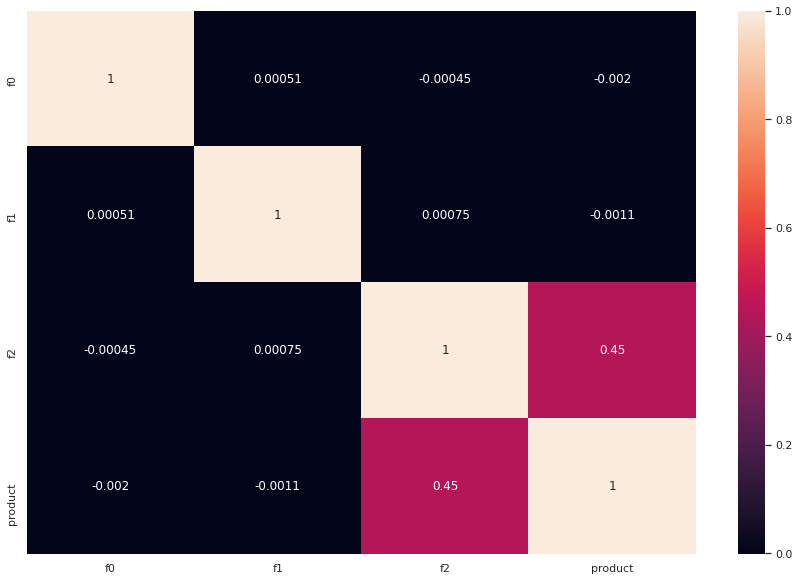

In [29]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(geo_2.corr(), annot=True)
plt.show()

Признаки "f0", "f1", "f2" если и коррелируют друг с другом, то совсем слабо. Представленные коэффициенты корреляции указывают на отстутствие проблемы мультиколлинеарности в данных.

---
**Вывод:** завершив этап загрузки и подготовки данных мы
- удалили в датасетах признак, лишний для наших целей обучения моделей - "id"; 
- не обнаружили пропусков в данных;
- проверили данные на дубликаты, обнаружили и удалили их;
- не обнаружили очевидных выбросов;
- проверили данные на мультиколлинеарность - её нет;
- отложили стандартизацию данных на этап подготовки пайплайнов.

## Обучение и проверка модели

### Разбиение данных на выборки

Разобьем наши данные на обучающие и валидационные выборки в соотношении 75%:25%. Для удобства напишем функцию.

In [30]:
def geo_split(geo_data):
    features = geo_data.drop('product', axis=1)
    target = geo_data['product']

    X_train, X_test, y_train, y_test = train_test_split(
                                            features,
                                            target,
                                            train_size=train_size,
                                            random_state=random_state)
    
    return X_train, X_test, y_train, y_test

In [31]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = geo_split(geo_0)
X_train_1, X_valid_1, y_train_1, y_valid_1 = geo_split(geo_1)
X_train_2, X_valid_2, y_train_2, y_valid_2 = geo_split(geo_2)

### Подготовка preprocessing-шага для pipeline'а

Подготовим preprocessing-шаг для наших pipeline'ов.

В preprocessing-шаге мы будем стандартизировать числовые признаки f0, f1, f2

В последующих pipeline'ах мы будем постоянно использовать этот шаг.

In [32]:
numeric_features = ['f0', 'f1', 'f2'] # числовые признаки
numeric_transformer = Pipeline( # трансформер для числовых признаков
    steps=[
        ('scaler', StandardScaler())
    ]
)

preprocessor = ColumnTransformer( # препроцессор, комбинированный из наших трансформеров
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

### Обучение моделей - подбор гиперпараметров

В качестве модели будем использовать линейную регрессию с l2-регуляризацией - по условиям задания. Подбирать гиперпараметры будем с помощью GridSearchCV с механизмом кросс-валидации. 

Гиперпараметры для исследования:
 - алгоритм оптимизации ('svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga');
 - сила l2-регуляризации - альфа.
 
В качестве скоринга будем использовать RMSE.
 
 Для нашего удобства напишем функцию для обучения модели:

In [33]:
def ridge_grid_model(X_train, y_train):

    lr_pipe = Pipeline(steps=[ # Подготовим пайплайн для нашей модели
            ('preprocessor', preprocessor),
            ('model', Ridge())
    ])

    parameter_space = { # Пространство параметров, по которому будет искать лучшее решение GridSearchCV
        'model__alpha'       : [1,5,10,25,50],
        'model__solver'  : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        'model__random_state' : [random_state]
    }

    # В качестве скоринга мы используем отрицательное RMSE
    lr_grid = GridSearchCV(lr_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=10)

    lr_grid.fit(X_train, y_train)

    best_lr = lr_grid.best_estimator_ # Лучшая модель - для просмотра лучших гиперпараметров
    best_rmse_train = lr_grid.best_score_ # Лучшее значение RMSE
    
    return lr_grid, best_lr, best_rmse_train

---
Обучим модель ridge-регрессии на наборе данных **geo_0**:

In [34]:
%%time

lr_grid_0, best_lr_0, best_rmse_train_0 = ridge_grid_model(X_train_0, y_train_0)

CPU times: user 25.9 s, sys: 33.7 s, total: 59.6 s
Wall time: 59.8 s


In [35]:
print(f'Для набора данных geo_0:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_train_0}.')
print(f'    - гиперпараметры:')
best_lr_0

Для набора данных geo_0:
    - лучшая модель ridge-регрессии показала RMSE: -37.69613304558657.
    - гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=10, random_state=42, solver='saga'))])

---
Обучим модель ridge-регрессии на наборе данных **geo_1**:

In [36]:
%%time

lr_grid_1, best_lr_1, best_rmse_train_1 = ridge_grid_model(X_train_1, y_train_1)

CPU times: user 21.5 s, sys: 32.3 s, total: 53.8 s
Wall time: 53.8 s


In [37]:
print(f'Для набора данных geo_1:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_train_1}.')
print(f'    - гиперпараметры:')
best_lr_1

Для набора данных geo_1:
    - лучшая модель ridge-регрессии показала RMSE: -0.8895939771727501.
    - гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=1, random_state=42, solver='svd'))])

---
Обучим модель ridge-регрессии на наборе данных **geo_2**:

In [38]:
%%time

lr_grid_2, best_lr_2, best_rmse_train_2 = ridge_grid_model(X_train_2, y_train_2)

CPU times: user 27 s, sys: 32 s, total: 59.1 s
Wall time: 1min


In [39]:
print(f'Для набора данных geo_2:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_train_2}.')
print(f'    - гиперпараметры:')
best_lr_2

Для набора данных geo_2:
    - лучшая модель ridge-регрессии показала RMSE: -40.048086869178825.
    - гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Ridge(alpha=25, random_state=42, solver='sag'))])

### Проверка моделей на валидационной выборке

Проверим наши модели на валидационной выборке.

Для удобства напишем функцию, в которой у нас будет:

- создание предсказаний валидационной выборки;
- скоринг RMSE на валидационной выборке;
- подсчёт среднего запаса предсказанного сырья.

In [40]:
def valid_rmse_scoring(model, X_valid, y_valid):
    
    predictions = model.predict(X_valid)
    
    best_rmse_valid = mean_squared_error(y_valid, predictions, squared=False)
    
    mean_pred_product = predictions.mean()
    
    return best_rmse_valid, predictions, mean_pred_product

---

In [41]:
best_rmse_valid_0, predictions_0, mean_pred_product_0 = valid_rmse_scoring(lr_grid_0, X_valid_0, y_valid_0)

In [42]:
print(f'Для набора данных geo_0 на валидационной выборке:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_0}.')
print(f'    - средний запас предсказанного сырья: {mean_pred_product_0} тыс. баррелей')
print(f'    - истинный средний запас сырья: {y_valid_0.mean()} тыс. баррелей')

Для набора данных geo_0 на валидационной выборке:
    - лучшая модель ridge-регрессии показала RMSE: 37.68504824970936.
    - средний запас предсказанного сырья: 92.60974279806825 тыс. баррелей
    - истинный средний запас сырья: 92.38876593595461 тыс. баррелей


---

In [43]:
best_rmse_valid_1, predictions_1, mean_pred_product_1 = valid_rmse_scoring(lr_grid_1, X_valid_1, y_valid_1)

In [44]:
print(f'Для набора данных geo_1 на валидационной выборке:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_1}.')
print(f'    - средний запас предсказанного сырья: {mean_pred_product_1} тыс. баррелей')
print(f'    - истинный средний запас сырья: {y_valid_1.mean()} тыс. баррелей')

Для набора данных geo_1 на валидационной выборке:
    - лучшая модель ridge-регрессии показала RMSE: 0.8928310731323991.
    - средний запас предсказанного сырья: 68.57703888177964 тыс. баррелей
    - истинный средний запас сырья: 68.58361591061642 тыс. баррелей


---

In [45]:
best_rmse_valid_2, predictions_2, mean_pred_product_2 = valid_rmse_scoring(lr_grid_2, X_valid_2, y_valid_2)

In [46]:
print(f'Для набора данных geo_2 на валидационной выборке:')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_2}.')
print(f'    - средний запас предсказанного сырья: {mean_pred_product_2} тыс. баррелей')
print(f'    - истинный средний запас сырья: {y_valid_2.mean()} тыс. баррелей')

Для набора данных geo_2 на валидационной выборке:
    - лучшая модель ridge-регрессии показала RMSE: 40.08060241293291.
    - средний запас предсказанного сырья: 94.93484766815911 тыс. баррелей
    - истинный средний запас сырья: 95.25463671658842 тыс. баррелей


---
Как мы видим, средний запас предсказанного сырья почти не отличается от истинного среднего, в этом наши модели адекватны.

### Проверка моделей на адекватность

Проверим наши модели на адекватность. Обучим модели-пустышки, заполняющие предсказания средним или медианным значением датасетов.

Проверим их RMSE и сравним с RMSE наших регрессий.

In [47]:
def dummy_grid_model(X_train, y_train, X_valid, y_valid):

    dummy_pipe = Pipeline(steps=[ # Подготовим пайплайн для нашей модели
            ('preprocessor', preprocessor),
            ('model', DummyRegressor())
    ])

    parameter_space = { # Пространство параметров, по которому будет искать лучшее решение GridSearchCV
        'model__strategy'  : ['mean', 'median']
    }

    # В качестве скоринга мы используем отрицательное RMSE
    dummy_grid = GridSearchCV(dummy_pipe, parameter_space, scoring='neg_root_mean_squared_error', cv=10)

    dummy_grid.fit(X_train, y_train)
    
    predictions = dummy_grid.predict(X_valid)
    best_rmse_valid = mean_squared_error(y_valid, predictions, squared=False) # Значение RMSE на валид. выборке
    
    return best_rmse_valid

---

In [48]:
dummy_rmse_valid_0 = dummy_grid_model(X_train_0, y_train_0, X_valid_0, y_valid_0)

In [49]:
print(f'Для набора данных geo_0 на валидационной выборке:')
print(f'    - лучшая модель пустышка показала RMSE: {dummy_rmse_valid_0}.')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_0}.')

Для набора данных geo_0 на валидационной выборке:
    - лучшая модель пустышка показала RMSE: 44.24507845228501.
    - лучшая модель ridge-регрессии показала RMSE: 37.68504824970936.


---

In [50]:
dummy_rmse_valid_1 = dummy_grid_model(X_train_1, y_train_1, X_valid_1, y_valid_1)

In [51]:
print(f'Для набора данных geo_1 на валидационной выборке:')
print(f'    - лучшая модель пустышка показала RMSE: {dummy_rmse_valid_1}.')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_1}.')

Для набора данных geo_1 на валидационной выборке:
    - лучшая модель пустышка показала RMSE: 45.96481261084314.
    - лучшая модель ridge-регрессии показала RMSE: 0.8928310731323991.


---

In [52]:
dummy_rmse_valid_2 = dummy_grid_model(X_train_2, y_train_2, X_valid_2, y_valid_2)

In [53]:
print(f'Для набора данных geo_2 на валидационной выборке:')
print(f'    - лучшая модель пустышка показала RMSE: {dummy_rmse_valid_2}.')
print(f'    - лучшая модель ridge-регрессии показала RMSE: {best_rmse_valid_2}.')

Для набора данных geo_2 на валидационной выборке:
    - лучшая модель пустышка показала RMSE: 44.66937952025659.
    - лучшая модель ridge-регрессии показала RMSE: 40.08060241293291.


Наши модели ридж-регрессий справляются лучше моделей-пустышек. Проверка на адекватность пройдена.

---
**Вывод:** завершив этап обучения и проверки моделей мы
- разбили данные на обучающие и валидационные выборки; 
- подготовили preprocessing-шаг для пайплайна, в ходе этого шага мы стандартизируем числовые признаки;
- обучили наши модели линейной регрессии с l2-регуляризацией;
- проверили наши модели на валидационной выборке - для набора geo_0 значение RMSE равно 37.7, а средний запас предсказанного сырья 92.6; для набора geo_1 значение RMSE равно 0.9 , а средний запас предсказанного сырья 68.6; для набора geo_2 значение RMSE равно 40.1 , а средний запас предсказанного сырья 94.9;
- средний запас предсказанного сырья почти не отличается от истинного среднего;
- проверили наши модели на адекватность - все прошли проверку.

## Подготовка к расчёту прибыли

### Расчёт безубыточного объёма сырья

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 

Из условий задачи:
 - при разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;
 - бюджет на разработку скважин в регионе — 10 млрд рублей;
 - при нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [54]:
BOREHOLE = 500 # Количество исследуемых точек
BEST_BOREHOLE = 200 # Количество лучших выбранных точек для разработки
BUDGET = 1e10 # Бюджет на разработку скважин
ONE_THOUSAND_BARRELS = 45e4 # Доход с единицы продукта

In [55]:
no_loss_product = BUDGET / (BEST_BOREHOLE * ONE_THOUSAND_BARRELS)

In [56]:
print(f'Достаточный объём сырья для безубыточной разработки новой скважины: {no_loss_product} тыс. баррелей.')
print(f'Средний запас сырья в регионе geo_0: {geo_0["product"].mean()} тыс. баррелей.')
print(f'Средний запас сырья в регионе geo_1: {geo_1["product"].mean()} тыс. баррелей.')
print(f'Средний запас сырья в регионе geo_2: {geo_2["product"].mean()} тыс. баррелей.')

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111 тыс. баррелей.
Средний запас сырья в регионе geo_0: 92.49968421774354 тыс. баррелей.
Средний запас сырья в регионе geo_1: 68.82391591804064 тыс. баррелей.
Средний запас сырья в регионе geo_2: 94.99834211933378 тыс. баррелей.


---
Ни у одного региона средний запас сырья не дотягивает до безубыточного. Пока рано делать вывод о том, какой регион привлекательней.

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 - выберем скважины с максимальными значениями предсказаний;
 - просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
 - рассчитаем прибыль для полученного объёма сырья.

In [57]:
def revenue(target, predictions, count):
    preds_sorted = predictions.sort_values(ascending=False)
    selected = target[preds_sorted.index][:count]


    # КОД РЕВЬЮЕРА, debug
    if target[preds_sorted.index].shape[0] > preds_sorted.shape[0]:
        print("Shape mismatch! Targets shape:", target[preds_sorted.index].shape[0])


    return (ONE_THOUSAND_BARRELS * selected.sum() - BUDGET)

In [68]:
# КОД РЕВЬЮЕРА
print(
    revenue(y_valid_0, predictions_0, BEST_BOREHOLE),
    revenue(y_valid_1, predictions_1, BEST_BOREHOLE),
    revenue(y_valid_2, predictions_2, BEST_BOREHOLE)
)

3468529787.422388 2415086696.681511 2396613000.939848


Для того, чтобы функция работала как надо, подготовим наборы предсказаний - превратим их из массивов numpy в объекты pd.Series и присвоим индексы целевых значений объемов сырья валидационных выборок.

In [58]:
predictions_0 = pd.Series(predictions_0, index=y_valid_0.index)
predictions_1 = pd.Series(predictions_1, index=y_valid_1.index)
predictions_2 = pd.Series(predictions_2, index=y_valid_2.index)

---
**Вывод**: завершив этап подготовки к расчёту прибыли, мы
- рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.1 тыс. баррелей;
- подготовили функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
Напишем для удобства функцию:

In [59]:
def bootstrap_revenue(target, predictions, n, count):
    
    revenue_values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=n, replace=True, random_state=state)
        preds_subsample = predictions[target_subsample.index]
        
        target_subsample.reset_index(inplace=True, drop=True)
        preds_subsample.reset_index(inplace=True, drop=True)
        
        revenue_values.append(revenue(target_subsample, preds_subsample, count))

    revenue_values = pd.Series(revenue_values)
    
    return revenue_values

In [60]:
revenue_values_0 = bootstrap_revenue(y_valid_0, predictions_0, BOREHOLE, BEST_BOREHOLE)
revenue_values_1 = bootstrap_revenue(y_valid_1, predictions_1, BOREHOLE, BEST_BOREHOLE)
revenue_values_2 = bootstrap_revenue(y_valid_2, predictions_2, BOREHOLE, BEST_BOREHOLE)

Напишем функцию для подчета статистик распределения прибыли:

In [61]:
def stats_revenue(revenue_values):
    print(f'Средняя прибыль равна: {revenue_values.mean()} руб.')
    print(f'95% доверительный интервал: {revenue_values.quantile(0.025)} - {revenue_values.quantile(0.975)} руб.')
    print(f'Риск убытков равен: {st.percentileofscore(revenue_values, 0)}%.')
    
    sns.histplot(revenue_values, bins=100)
    plt.axvline(x=revenue_values.quantile(0.025), ymin=0, ymax=1, linewidth=4, color='r', ls='--')
    plt.axvline(x=revenue_values.quantile(0.975), ymin=0, ymax=1, linewidth=4, color='r', ls='--')
    plt.text(x=(revenue_values.quantile(0.025)-0.03e9),y=15,s='2.5% квантиль',rotation=90)
    plt.text(x=(revenue_values.quantile(0.975)+0.01e9),y=15,s='97.5% квантиль',rotation=90)
    plt.xticks(np.arange(revenue_values.min(), revenue_values.max(), step=0.1e9))
    plt.title('Гистограмма распределения прибыли бутстрапированной выборки')
    plt.xlabel('Прибыль (в млрд. рублей)')
    plt.ylabel('Количество объектов из выборки')
    plt.show()

Рассчитаем статистики наших распределений:

Для региона geo_0:
Средняя прибыль равна: 403726181.23602927 руб.
95% доверительный интервал: -137690003.15147296 - 902848310.7781234 руб.
Риск убытков равен: 5.9%.


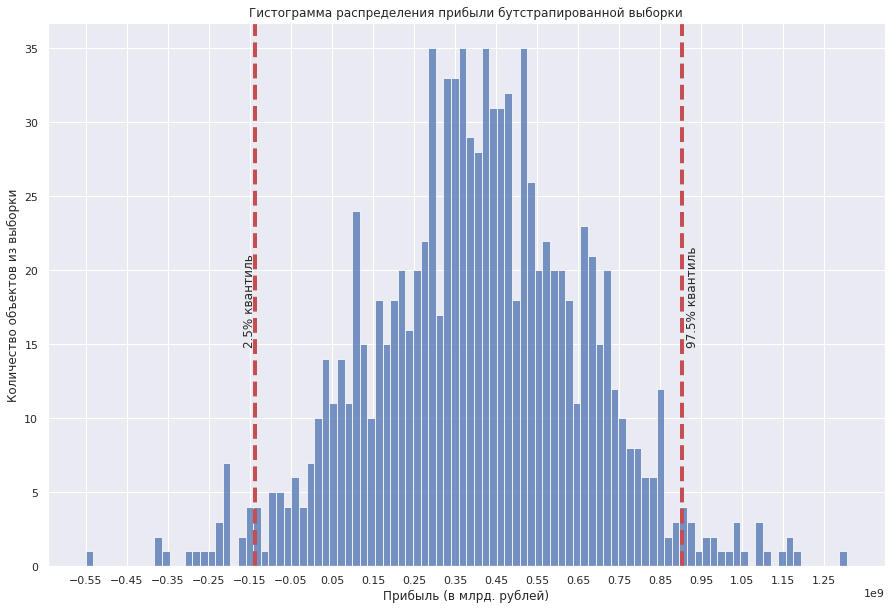

In [62]:
print('Для региона geo_0:')
stats_revenue(revenue_values_0)

Для региона geo_1:
Средняя прибыль равна: 439363670.3344077 руб.
95% доверительный интервал: 31747699.959269673 - 845875096.0724705 руб.
Риск убытков равен: 1.6%.


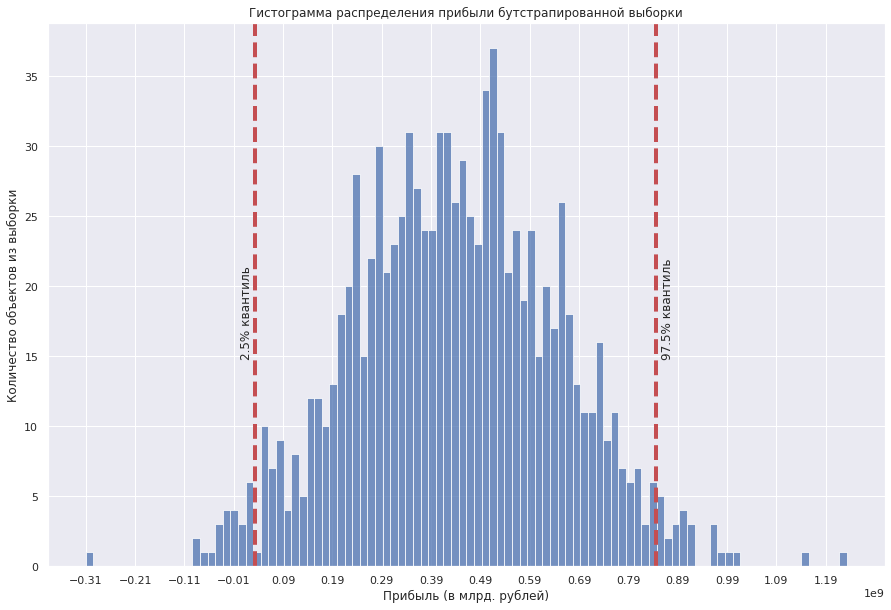

In [63]:
print('Для региона geo_1:')
stats_revenue(revenue_values_1)

Для региона geo_2:
Средняя прибыль равна: 367763622.7215769 руб.
95% доверительный интервал: -163242657.76534465 - 877126556.7342361 руб.
Риск убытков равен: 8.1%.


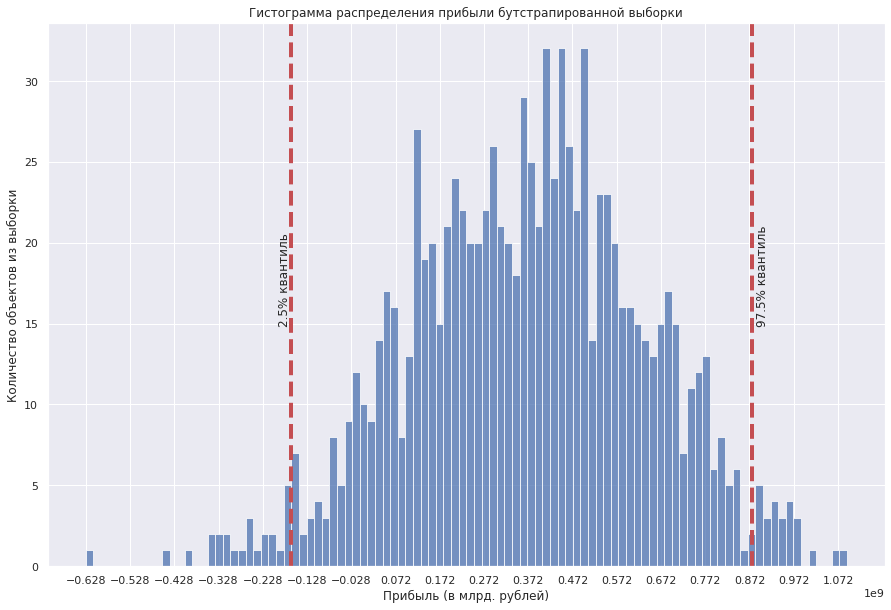

In [64]:
print('Для региона geo_2:')
stats_revenue(revenue_values_2)

---
**Вывод:** завершив этап расчёта прибыли и рисков, мы обнаружили наиболее перспективный регион для разработки скважин: 2-ой по счёту регион, geo_1. У данного региона наиболее высокая средняя прибыль - 439 млн. рублей и риск убытков составляет всего 1.6%, что практически в 4 и 5 раз меньше, чем в других регионах.

## Общий вывод

Сразу отвечая на главный вопрос проекта, мы обнаружили наиболее перспективный регион для разработки скважин: **2-ой по счёту регион, geo_1**. У данного региона наиболее высокая средняя прибыль - **439 млн. рублей** и риск убытков составляет всего **1.6%**, что практически в 4 и 5 раз меньше, чем в других регионах.

В целом, в ходе выполнения проекта:

- завершив этап загрузки и подготовки данных мы
    - удалили в датасетах признак, лишний для наших целей обучения моделей - "id"; 
    - не обнаружили пропусков в данных;
    - проверили данные на дубликаты, обнаружили и удалили их;
    - не обнаружили очевидных выбросов;
    - проверили данные на мультиколлинеарность - её нет;
    - отложили стандартизацию данных на этап подготовки пайплайнов.


- завершив этап обучения и проверки моделей мы
    - разбили данные на обучающие и валидационные выборки; 
    - подготовили preprocessing-шаг для пайплайна, в ходе этого шага мы стандартизируем числовые признаки;
    - обучили наши модели линейной регрессии с l2-регуляризацией;
    - проверили наши модели на валидационной выборке - для набора geo_0 значение RMSE равно 37.7, а средний запас предсказанного сырья 92.6; для набора geo_1 значение RMSE равно 0.9 , а средний запас предсказанного сырья 68.6; для набора geo_2 значение RMSE равно 40.1 , а средний запас предсказанного сырья 94.9;
    - проверили наши модели на адекватность - все прошли проверку.


- завершив этап подготовки к расчёту прибыли, мы
    - рассчитали достаточный объём сырья для безубыточной разработки новой скважины: 111.1 тыс. баррелей;
    - подготовили функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели.


- завершив этап расчёта прибыли и рисков, мы обнаружили наиболее перспективный регион для разработки скважин: 2-ой по счёту регион, geo_1. У данного региона наиболее высокая средняя прибыль - 439 млн. рублей и риск убытков составляет всего 1.6%, что практически в 4 и 5 раз меньше, чем в других регионах.
